# **Lab 9 (SOLUTIONS)**

TI3155TU Deep Learning (2024 - 2025)

Adapted by Elena Congeduti from TU Delft IFEEMCS520100 Fundamentals of Artificial Intelligence Programme and https://github.com/lazyprogrammer/machine_learning_examples

# Instructions
We recommend that you fork the lab notebooks by selecting `Copy & Edit` on the notebook's homepage. This will create a copy in your Kaggle repository, allowing you to work on it and save your progress as you go. Kaggle provides a pre-configured virtual environment, which means that most of the libraries we will use are already downloaded and ready to use. Therefore, you typically do **not** need to `pip install` additional resources.

Alternatively, to work on Google Colab, you just need to select the `Open in Colab` option in the notebook's homepage menu. Finally, if you want to work locally, you will need to set up your own virtual environment. Check the Lab Instructions in [Learning Material](https://brightspace.tudelft.nl/d2l/le/content/682797/Home?itemIdentifier=D2L.LE.Content.ContentObject.ModuleCO-3812764) on Brightspace for detailed information on the virtual environment configuration.

These labs include programming exercises and insight questions. Follow the instructions in the notebook. Fill in the text blocks to answer the questions and write your own code to solve the programming tasks within the designated part of the code blocks:

```python
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################


#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################
```

Solutions will be shared the week after the lab is published. Note that these labs are designed for practice and are therefore **ungraded**.

In [1]:
# Setup
!pip install gymnasium
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week12-MDPs/gridWorldGame.py

import gymnasium as gym
import numpy as np
from collections.abc import Iterable

from IPython import display
import matplotlib.pyplot as plt
import pylab as pl
from gridWorldGame import standard_grid, print_values, print_policy

--2024-12-08 10:36:46--  https://raw.githubusercontent.com/lcharlin/80-629/master/week12-MDPs/gridWorldGame.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3800 (3.7K) [text/plain]
Saving to: 'gridWorldGame.py'

gridWorldGame.py    100%[===================>]   3.71K  --.-KB/s    in 0s      

2024-12-08 10:36:46 (72.4 MB/s) - 'gridWorldGame.py' saved [3800/3800]



# 1 Markov Decision Processes

In this lab we will use two example domains. The first domain is a variant of the classical `MountainCar-v0` from OpenAI gym. An agent has the goal to guide a car at the top of a hill by controlling the car's acceleration direction. The process is described by the following components of a Markov decision process (MDP). The state space corresponds to the car's position $x$ and velocity $v$, i.e. $s=(x,v)\in S\subset \mathbb{R}^2$ according to the coordinates you see in the figure below. The agent can choose from three discrete actions which control the acceleration $a\in A = \{ \text{left},\,\text{none},\,\text{right}\}$. These actions are mapped to numerical values as follows A = \{0,1,2\}. The reward is 1 if the goal on the top of the right hill is reached and 0 otherwise. The transitions follow the physics dynamics determined by gravitation and with no friction.

The class `MountainCar` describes the environment for this reinforcement learning task. You can start a new episode with `reset()` and execute an `action` with `step(action)`.

<div style="display: flex; justify-content: space-between;">
  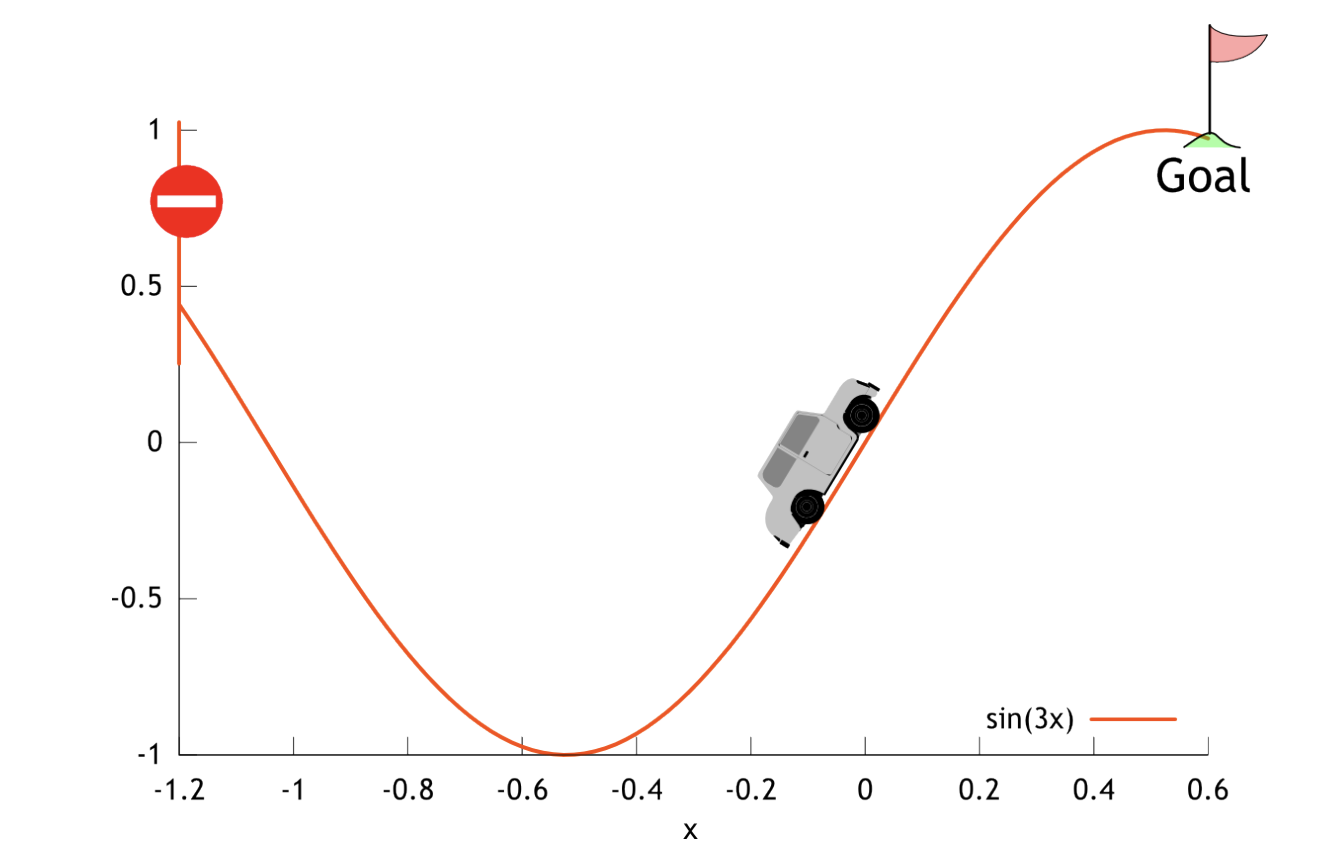
  <img src="https://user-images.githubusercontent.com/10624937/42135605-ba0e5f2c-7d12-11e8-9578-86d74e0976f8.gif" alt="Image 2" style="width: 47%;"/>
</div>
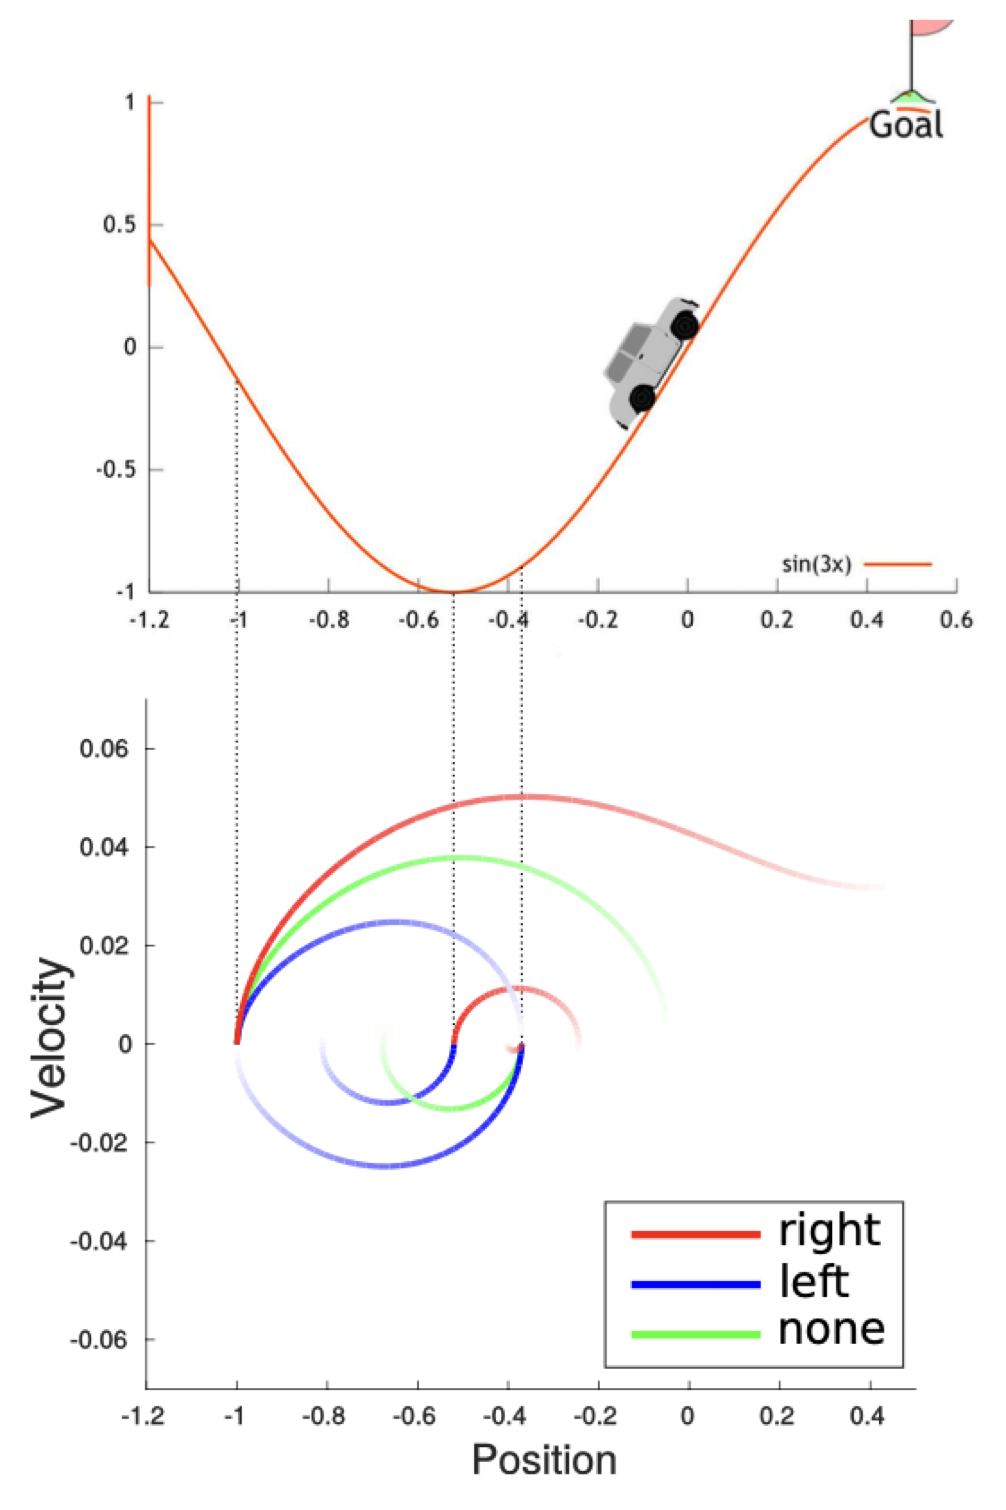

In [2]:
class MountainCar (gym.Wrapper):
  
    def __init__(self):
        
        super().__init__(env=gym.make('MountainCar-v0'))
        self._elapsed_steps = self.env._elapsed_steps

    def reset(self):
        
        """ Starts a new episode and returns the first state. """
        
        self._elapsed_steps = 0
        return self.env.reset()[0]

    def step(self, action):
        
        """ Executes an `action` in the current state. Returns the `next_state`, the received `reward`,
            a boolean `done` indicating whether the episode is finished (terminal or timeout), and
            a boolean `terminal` indicating whether a `done` episode ended in a terminal state."""
       
        next_state, _, terminal, truncated, _ = super().step(action)
        self._elapsed_steps += 1
        done = truncated or terminal
        reward = 1 if terminal else 0

        return next_state, reward, done, terminal

****

**Question 1.1:** Try to epxlore the class methods `reset` and `step`. Which elements of the MDP (states, actions, transitions and rewards) correpond to the inputs/outputs of these methods?

In [3]:
#Call the class methods to check input/output and what they do
env = MountainCar()

#Initialize the environmnet
s0=env.reset()
print('Initial state',s0)

#Perform one environment step for action a = left 
s1, r1, done, terminal = env.step (0)

print('\nFirst state,',s1)
print('First reward,',r1)
print('Is it the episode over?',done)
print('Is this a terminal state?',terminal)

#Perform a second environment step for action a = none 
s2, r2, done, terminal = env.step (2)
print('\nSecond state,',s2)
print('Second reward,',r2)
print('Is it the episode over?',done)
print('Is this a terminal state?',terminal)

Initial state [-0.4042452  0.       ]

First state, [-0.40612134 -0.00187615]
First reward, 0
Is it the episode over? False
Is this a terminal state? False

Second state, [-0.40786043 -0.0017391 ]
Second reward, 0
Is it the episode over? False
Is this a terminal state? False


<font color='green'> $ MDP = \langle S, A, \rho, P, R \rangle$

- `reset()`:

    - output corresponds to the initial state of one episode $s^0 \sim \rho, s^0 \in S,$ 

- `step()`:

    - input `action` corresponds to action $a^t \sim \pi(s^t), a^t \in A$ at time step $t$

    - output `next_state` corresponds to the next state $s^{t+1} \sim P(\cdot|s^t, a^t), s^{t+1} \in S$ after excuting $a^t \in A$ in $s^t \in S$

    - output `reward` corresponds to the immediate reward $r^t = R(s^t, a^t) \in \mathbb R$ earned by executing $a^t \in A$ in $s^t \in S$

    - output `done` indicates the end of the episode

    - output `terminal` indicates whether a `done` step is terminal or timeout
  </font>



****

In this lab, we will also use an example introduced in class: robot navigation in a gridworld. At each time step, the agent chooses to move in one orthogonal direction with deterministic transitions, meaning the robot always succeeds in making the intended step (with probability 
1). In this version, the robot navigates in a 3x4 gridworld with a wall. The state space is represented by the 2D coordinates $(i,j)$ where $i$ represents the row and $j$ the column index and the origin $(0,0)$ corresponds to the top left corner of the grid.

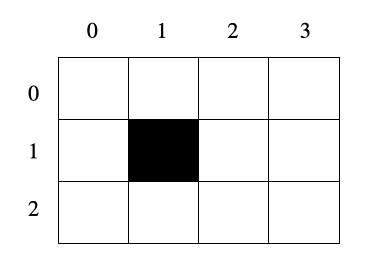

Let us set up the environment and explore all its features.

In [4]:
#Define the discount factor
GAMMA = 0.9

# Define all the possible actions  up,down, left, right
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R') 

#Define the environmnet
grid = standard_grid(noise_prob=0)

#Check the state space coordinates
print('State Space')
print(grid.all_states())

#Check the initial state
print('\nInitial State')
s_init=grid.current_state()
print(s_init)

#Check the coordinates of the action available in the current state
print('\nActions available in the initial state state')
print(grid.actions[s_init])

State Space
{(0, 1), (1, 2), (2, 1), (0, 0), (0, 3), (2, 0), (2, 3), (0, 2), (2, 2), (1, 0), (1, 3)}

Initial State
(2, 0)

Actions available in the initial state state
('U', 'R')


****
**Question 1.2:** What is the state space? Where does the process start, and why are only two actions available?


<font color='green'> There are 11 possible states, represented by their (row, column) coordinates with the exception (1,1), which is occupied by a wall. The robot starts its navigation in the bottom-left corner of the grid  $s^0=(2,0)$. From there, it can only decide to go right or up due to the boundaries of the gidworld.</font>

****

There are two terminal states: $(0,3)$ and $(1,3)$. This means that once the agent reaches any of these states, the process will terminate. Moreover, the process terminates when the robot bumps into the wall $(1,1)$. When the process ends, a new episode begins from a new initial state.

In [5]:
#Check if the current state is terminal
print(f'Is the current state {s_init} terminal? {grid.is_terminal(s_init)}')

Is the current state (2, 0) terminal? False


In [6]:
print("\nMap of the rewards:")
print_values(grid.rewards, grid)


Map of the rewards:
---------------------------
 0.00| 0.00| 0.00| 1.10|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


As you can see, the two terminal states are quite different: in $(0,3)$ the agent will receive a positive reward of $1.1$ while in $(1,3)$ it receives a negative reward of $-1$.

Remember that a policy is a function that maps states to actions $\pi : S \rightarrow A$. The goal of the robot is to find the policy that maximizes the sum of discounted rewards that it expects to collect by following that policy, i.e. $\pi^* = \text{argmax}_{\pi} V^{\pi}(s)$.

Let's define a random initial policy $\pi$.

In [7]:
#initial random policy
policy = {}

for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

#Visualize the policy as one action for any state in the grid
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  L  |  D  |  R  | N/A |
---------------------------
  L  | N/A |  R  | N/A |
---------------------------
  U  |  L  |  U  |  U  |


Note that no action (Not Available "N/A") is specified in the terminal states and at the wall, as the episode ends when the robot reaches these states.

# 2 Value Iteration
We will use Value Iteration (VI) to learn the optimal policy $\pi^*$. Remember that for each iteration 
$k$, the value of a state $s$, $V^{k}(s)$ updated according to the following formula:

\begin{align}
V^{k}(s) &= \max_a \left\{ R(s,a) + \gamma\sum_{s'}  P(s'|s,a)V^{k-1}(s')\right \}
\end{align}
⁡
Since value iteration is an iterative algorithm, we need to initialize the value function by defining $V^0$. Keep in mind that the algorithm converges to the optimal value function regardless of the initialization. This means that after a large number of iterations $k$, $V^{k}\approx V^*(s)$ for any choice of the initial value function $V^0$. Thus, we initialize the value function with random numbers between 0 and 1.

In [8]:
np.random.seed(42)

#Intialization of the value function
V = {}
states = grid.all_states()

for s in states:
    if s in grid.actions:
        #Non-terminal states set a random value between 0 and 1
        V[s] = np.random.random()
    else:
        #Terminal state set 0
        V[s] = 0

# Initial value for all states in grid
print_values(V, grid)

---------------------------
 0.60| 0.37| 0.06| 0.00|
---------------------------
 0.60| 0.00| 0.95| 0.00|
---------------------------
 0.16| 0.73| 0.87| 0.16|


Note that we set to 0 the values of the terminal states.

****
**Task 2.1:** For any state $s$, implement the update steps for the value function:
1. For an action $a$ compute the Q-value

  $$
  q \longleftarrow R(s,a)+\gamma \sum_{s'}P(s'|s,a)V^{k-1}(s')
  $$

2. If $q$ is higher than the maximum Q-value over the previous actions store `q` as the new value for $V^{k}$, `new_v`.

Remember that in the current gridworld $P(s'|s,a)$ is deterministic, so you have to sum only one term.

Run the algorithm until convergence, i.e. until $\max_{s}|V^{k}(s)-V^{k-1}(s)|$ is smaller than the threshold`SMALL_ENOUGH`.
****

In [9]:
#threshold to declare VI convergence
SMALL_ENOUGH = 1e-3 

#VI interation k
iteration=0

while True:
    print("VI iteration %d: " % iteration)
    print_values(V, grid)
    print("\n\n")
  
    Delta = 0
    
    #for each state s compute V^k(s)
    for s in states:
        
        #Store the previous value V^(k-1)(s) in old_v
        old_v = V[s]
        
        #Updates V^{k}(s) only if s is non-terminal state otherwise leave 0
        if s in policy:
            
            #Candidate optimal value V*
            new_v = float('-inf')

            #for each action
            for a in ALL_POSSIBLE_ACTIONS:

                #Set the grid in state s
                grid.set_state(s)
                
                #Perform one environment step from state s according to action a
                #Get the reward r
                r = grid.move(a)
                
                #Get next state s'
                next_s = grid.current_state()

                ################################################################
                #                            START OF YOUR CODE                #
                ################################################################
                q = r + GAMMA * V[next_s]
                if q > new_v:
                    new_v = q
                ################################################################
                #                         END OF YOUR CODE                     #
                ################################################################
            V[s] = new_v
            Delta = max(Delta, np.abs(old_v - V[s]))

    print('\t biggest change is: %f \n\n' % Delta)
    if Delta < SMALL_ENOUGH:
        break
    iteration+=1

print('Optimal Value')
print_values(V, grid)

VI iteration 0: 
---------------------------
 0.60| 0.37| 0.06| 0.00|
---------------------------
 0.60| 0.00| 0.95| 0.00|
---------------------------
 0.16| 0.73| 0.87| 0.16|



	 biggest change is: 1.041916 


VI iteration 1: 
---------------------------
 0.54| 0.54| 1.10| 0.00|
---------------------------
 0.63| 0.00| 0.86| 0.00|
---------------------------
 0.70| 0.78| 0.78| 0.78|



	 biggest change is: 0.451207 


VI iteration 2: 
---------------------------
 0.89| 0.99| 1.10| 0.00|
---------------------------
 0.80| 0.00| 0.99| 0.00|
---------------------------
 0.63| 0.70| 0.89| 0.70|



	 biggest change is: 0.100297 


VI iteration 3: 
---------------------------
 0.89| 0.99| 1.10| 0.00|
---------------------------
 0.80| 0.00| 0.99| 0.00|
---------------------------
 0.72| 0.80| 0.89| 0.80|



	 biggest change is: 0.000000 


Optimal Value
---------------------------
 0.89| 0.99| 1.10| 0.00|
---------------------------
 0.80| 0.00| 0.99| 0.00|
---------------------------
 0.7

Now that the we have the optimal value function, we want to use it to find the optimal policy $\pi^*$.

****

**Task 2.2:** Use the optimal value function $V^*$ to compute the Q-values $Q(s,a)$ as

$$
Q(s,a)= R(s,a) + \gamma\sum_{s'} P(s'|s,a)V^*(s')
$$

Store the action $a$ that maximizes the Q-value in `best_a`.

****

In [10]:
#for any state s
for s in policy.keys():
    
    #Candidate best action 
    best_a = None
    #Candidate best q value 
    best_value = float('-inf')

    #for any action a
    for a in ALL_POSSIBLE_ACTIONS:
        #Set the grid in state s
        grid.set_state(s)
        
        #Perform one environment step from state s according to action a
        #Get the reward r
        r = grid.move(a)
        
        #Get next state s'
        next_s = grid.current_state()

        ########################################################################
        #                            START OF YOUR CODE                        #
        ########################################################################
        q = r + GAMMA * V[next_s]
        if q > best_value:
            best_value = q
            best_a = a
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

    policy[s] = best_a

Now print your optimal policy and corresponding optimal value.

In [11]:
print("values:")
print_values(V, grid)
print("\npolicy:")
print_policy(policy, grid)

values:
---------------------------
 0.89| 0.99| 1.10| 0.00|
---------------------------
 0.80| 0.00| 0.99| 0.00|
---------------------------
 0.72| 0.80| 0.89| 0.80|

policy:
---------------------------
  R  |  R  |  R  | N/A |
---------------------------
  U  | N/A |  U  | N/A |
---------------------------
  U  |  R  |  U  |  L  |


Where does your optimal policy lead? If you see the robot following the shortest path to the upper-right corner state of the grid, where it collects the highest reward, your implementation is correct, and you have found the optimal policy!

# 3 Tabular Q-learning

We have solved a planning task in the gridworld scenario using value iteration. Now we consider the mountain car problem introduced in the first section of the notebook. Unlike the grid-world scenario, this is an actual reinforcement learning task because the dynamics of the environment are unknown. Thus, we cannot update the Q-values using exact transition functions. Instead, as the agent interacts with the environment, we can observe state transitions and rewards and update its Q-values iteratively to approximate the optimal values $Q^*(s,a)$.

We will use the class `ValueFunction` below later to store a table of Q-values.

In [12]:
class ValueFunction:

    """ Defines a tabular Q-value function for a given environment and
        optionally a resolution (int or Iterable of int) and
        optionally some 'state_bounds' (list of 2-tuples, one for each state dimension).

        For example, defining 'q = ValueFunction(env)' allows to:
        set values with
            'q[state] = [value_1, ..., value_num_actions]' or
            'q[state, action] = single_value', and
        get values with
            'q[state]' returns an array with the values of all actions or
            'q[state, action]' returns the value of the given 'action'."""

    def __init__(self, env, resolution=50, state_bounds=None, init_value=0.0):

        # derive the action space
        assert isinstance(env.action_space, gym.spaces.Discrete), "The environment must have discrete actions."
        self.num_actions = env.action_space.n
        # derive the the state space
        if state_bounds is None:
            self.bounds = [(l, h) for l,h in zip(env.observation_space.low, env.observation_space.high)]
        else:
            self.bounds = state_bounds
        self.resolution = resolution if isinstance(resolution, Iterable) else [resolution for _ in self.bounds]
        assert len(self.resolution) == len(self.bounds), \
                "The resolution and state bounds must be consistent with the given environment."
        # define other properties
        self.eps = 1E-7
        # define the lookup table for the values
        self.shape = (*self.resolution, self.num_actions)
        self.val = np.ones(self.shape) * (init_value)  # + self.eps)

    def state_bin(self, state):
        """ Find the correct bin in 'self.count' for one state. """
        return tuple([int((x - l) / (h - l + self.eps) * r) for x, (l, h), r in zip(state, self.bounds, self.resolution)])

    def __setitem__(self, key, newvalue):
        assert isinstance(key, Iterable) and len(key) > 0, \
                    "x[state] = actions or x[state, action] = value"
        if isinstance(key[0], Iterable) and len(key) > 1:
            assert key[1] >= 0 and key[1] < self.num_actions, \
                    "illegal action %u, must be between 0 and %u" % (key[1], self.num_actions-1)
            self.val[self.state_bin(key[0])][key[1]] = newvalue
        else:
            assert len(newvalue) == self.num_actions, \
                    "wrong size %u of value-vector, must be %u" % (len(newvalue), self.num_actions)
            self.val[self.state_bin(key)] = newvalue

    def __getitem__(self, key):
        assert isinstance(key, Iterable) and len(key) > 0
        if isinstance(key[0], Iterable) and len(key) > 1:
            return self.val[self.state_bin(key[0])][key[1]]
        else:
            return self.val[self.state_bin(key)]

****

**Task 3.1:** To make sure that you can use the `ValueFunction` class:
1. Overwrite the Q-value of state $s=(0.5,0)$ and action $a=1$ with the value 2
2. Print the Q-values for state $s=(0.5,0)$
3. Print the Q-values of state $s=(0.4, 0)$
****

In [13]:
#Define the value function as a table for the Mountain car and initialize all the values of the table to 1
q = ValueFunction(env=MountainCar(), resolution=5, init_value=1)

s1 = (0.5,0)
s2 = (0.4,0)

print('Q-value of state s1=(0.5,0)',q[s1])
print('Q-value of state s2=(0.4,0)',q[s2])

########################################################################
#                            START OF YOUR CODE                        #
########################################################################
q[s1, 1] = 2
print('\nQ-values of state s1 = (0.5,0) ',q[s1])
print('Q-values of state s2 =(0.4,0)',q[s2])
########################################################################
#                         END OF YOUR CODE                             #
########################################################################



Q-value of state s1=(0.5,0) [1. 1. 1.]
Q-value of state s2=(0.4,0) [1. 1. 1.]

Q-values of state s1 = (0.5,0)  [1. 2. 1.]
Q-values of state s2 =(0.4,0) [1. 2. 1.]


The Q-values of states $s_1=(0.5, 0)$ and $s_2=(0.4, 0)$ are identical, even though $s_2$ has never been updated. This occurs because of the resolution chosen. Infact, the position and velocity are discretized in order to create tabular Q-values. For `resolution=5`, the continuous state space is partitioned into a table of $5\times 5$ position-velocity intervals, causing the two states $s_1$ and $s_2$ to be mapped into the same table entry.

****
**Question 3.2:** What happens if you choose higher resolution e.g. `resolution=10`?


<font color='green'> Now we are building a table with $10\times 10$ entries. With this finer discretization, $s_1$ and $s_2$ are not mapped into the same the table entry and therefore their Q-values can be different. </font>
****

Now we build a q-learning agent. We want to implement the method `learn` of the class `QLearningAgent` that updates the Q-values according to the temporal difference update:

$$Q(s,a)\longleftarrow Q(s,a)+ \alpha (r + \gamma\max_{a'} Q(s',a')-Q(s,a))$$

The method receives a starting `state`, an `action` that is executed in `state`, a `next_state` observed after executing `action`, a `reward` received after executing `action` and transition to `next_state` and a boolean `terminal` that is `True` if `next_state` is a terminal state (i.e. the goal of MountainCar is reached).

****
**Task 3.3:** Complete the method `learn`:
1. Compute the next Q-values as $\max_{a'}Q(s',a')$. Make sure that this is correct in `terminal` states, i.e., after the transition into `next_state`, no further rewards are received and accounted for in the learned Q-values.
2. Commpute the temporal difference $td$
3. Update the the Q-values in `self.q`
****

In [14]:
class QLearningAgent:

    def __init__(self, env, alpha=0.5, gamma=0.99, resolution=50, init_value=1.0):
        #Build the q-table
        self.q = ValueFunction(env, resolution=resolution, init_value=init_value)
        #learning rate
        self.alpha = alpha
        #discount factor
        self.gamma = gamma

    def choose(self, state):
        return np.argmax(self.q[state])

    def learn(self, state, action, next_state, reward, terminal):

        ########################################################################
        #                            START OF YOUR CODE                        #
        ########################################################################
        #Compute next q value
        #Set it to zero if s' is terminal
        if terminal:
            next_q_value = 0
        #Set it to the maximum over the actions max_a' (Q(s',a'))
        else:
            next_q_value=np.max(self.q[next_state])
            
        #Compute temporal difference td   
        td = reward + self.gamma * next_q_value - self.q[state, action]
        
        #Update q values
        self.q[state, action] += self.alpha * td
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

****

**Question 3.4:** What does the method `choose` do?

<font color='green'> It encodes the policy of the q-learning agent: given an input state returns the action with highest Q-value. Therefore, when the optimal Q-values have been learned, the method defines an optimal policy $\pi^*$.</font>

****

# 4 RL training loop

Let our agent now interact with the environment to collect the experience and progressively update the q-values and its policy.

The following class `RLExperiment` is supposed to learn the `MountainCar` environment using the above `QLearningAgent`. The class also manages experiment results and plots learning curves, q-values and policies in regular intervals. Due to its complexity, it is not necessary that you fully understand it, you must just implement the `train_episode()` method (no other methods need to be modified).

****
**Task 4.1:** Complete the method `train_episode()`:
- Start a new episode
- Until the environment returns `done==True`:
  1. Choose an action with the Q-learning agent `self.agent`
  2. Perform one environment step
  3. Update the Q-learning agent with the method `learn` (at every environment step)
  4. Accumulate the reward in the `episode_return` that is the sum of all the experienced rewards during this episode

The function must return the `episode_return`.
****

In [15]:
class RLExperiment:

    """ Main class that initializes, runs and plots an RL experiment. """
    def __init__(self, alpha=0.5, gamma=0.95, resolution=50, init_value=1, plot_interval=50):

        self.plot_results = plot_interval > 0
        self.plot_interval = plot_interval
        self.env = MountainCar()
        self.max_episode_length = self.env.spec.max_episode_steps
        self.init_value = init_value
        self.agent = QLearningAgent(self.env, alpha=alpha, gamma=gamma, resolution=resolution, init_value=init_value)
        self.episode_returns = []
        self.env_steps = []


    def _plot_states(self, image, colormap='jet', ticks=None):

        """ Internal method that plots a colorplot of some image.
             You do not need to understand (or change) the details of this method. """
        # colorplot of 'image' and a white finish line
        pl.imshow(np.transpose(np.flip(image, axis=1), (1, 0)), cmap=colormap)
        idx = self.agent.q.state_bin((0.5, 0))
        pl.plot([idx[0]-0.5, idx[0]-0.5], [0, image.shape[1]-1], 'w:')
        idx = self.agent.q.state_bin((-0.5, 0))
        pl.xticks([-0.5, idx[0], self.agent.q.val.shape[0] - 0.5], [-1.2, -0.5, 0.6])
        pl.xlabel('position')
        pl.yticks([-0.5, idx[1], self.agent.q.val.shape[1] - 0.5], [0.07, 0, -0.07])
        pl.ylabel('velocity')

        # add a colorbar with the given 'colormap' (and eventually with the defined 'ticks')
        if ticks is None:
            pl.colorbar()
        else:
            cbar = pl.colorbar(ticks=[i - 1 for i in range(len(ticks))])
            cbar.ax.set_yticklabels(ticks)  # vertically oriented colorbar

    def _plot_training(self, update=False):

        """ Plots logged training results. Use "update=True" if the plot is continuously updated
            or use "update=False" if this is the final call (otherwise there will be double plotting).
            You do not need to understand (or change) the details of this method. """
        # Smooth curves
        window = max(int(len(self.episode_returns) / 50), 10)
        if len(self.episode_returns) < window + 2: return
        returns = np.convolve(self.episode_returns, np.ones(window)/window, 'valid')
        env_steps = np.convolve(self.env_steps, np.ones(window)/window, 'valid')

        # Create plot
        colors = ['b', 'g', 'r']
        fig = plt.gcf()
        fig.set_size_inches(16, 4)
        plt.clf()

        # Plot the returns in the left subplot
        pl.subplot(1, 3, 1)
        pl.plot(env_steps, returns, colors[0])
        pl.xlabel('environment steps')
        pl.ylabel('averaged episode return')

        # Plot the value function in the second plot

        pl.subplot(1, 3, 2)
        self._plot_states(self.agent.q.val.max(axis=-1))
        pl.title('values')

        # Plot the policy in the third plot
        pl.subplot(1, 3, 3)
        policy = np.argmax(self.agent.q.val, axis=-1)
        policy[(self.agent.q.val == self.init_value).all(axis=-1)] = -1
        self._plot_states(policy, colormap='gnuplot', ticks=['unvisited', 'left', 'none', 'right'])
        pl.title('policy')

        # dynamic plot update
        display.clear_output(wait=True)
        if update:
            display.display(pl.gcf())

    def close(self):

        """ Closes the environment (free resources). Do not change this method. """
        self.env.close()

    def train(self, num_episodes=float('inf'), max_env_steps=float('inf')):

        """ Trains a RL agent for `num_episodes` or until `max_env_steps`.
            Do not change this method! """
        env_steps, episode = 0, 0
        while episode < num_episodes and env_steps < max_env_steps:
            episode_return = self.train_episode()

            #increase counter of steps
            env_steps += self.env._elapsed_steps
            episode += 1

            #store returns
            self.episode_returns.append(episode_return)
            self.env_steps.append(env_steps)

            #plot the loss, values and policy

            if self.plot_results and (episode + 1) % self.plot_interval == 0:
                self._plot_training(update=True)

        if self.plot_results:
            self._plot_training(update=False)

    def train_episode(self):

        """ Run and train the agent with one episode """
        ########################################################################
        #                            START OF YOUR CODE                        #
        ########################################################################
        #Set an initial state
        state = self.env.reset()
        
        #Set the initial episode return to 0, and done to False
        done, episode_return = False, 0

        #Untile the episose is not done
        while not done:
            #let the q-learning agent select an action give the current state
            action = self.agent.choose(state)
            #perform one environment step
            next_state, reward, done, terminal = self.env.step(action)
            #update q-agent according to the transition
            self.agent.learn(state, action, next_state, reward, terminal)
            #cumulate reward in the episode return
            episode_return += reward
            #reset the current state
            state = next_state

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################
        return episode_return

Now let's test our implementation by running Q-learning for 2 million environment steps using the following parameters:

- learning rate `alpha=0.5`

- discount factor `gamma=0.99`

- discretization `resolution=31`

- table initialization `init_val=1`

Hint: it will run much faster with a GPU or TPU accelerator.

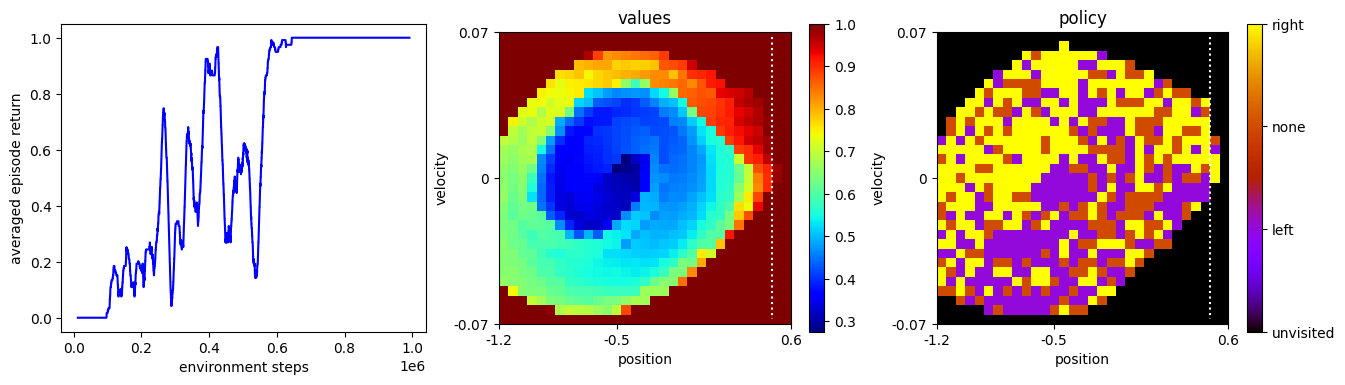

In [16]:
ex = RLExperiment(alpha=0.5, gamma=0.99, resolution=31, init_value=1)
ex.train(max_env_steps=1E6)

****

**Question 4.2:** What does the first plot on the left side represents? Do you think that the q-learning agent is able to learn an effective policy?

<font color = 'green'> The first figure shows the progression of the average episode return, which is the sum of the rewards collected in one episode during training. The plot should show the return increasing until it reaches approximately 1. At that point, the agent has learned a policy that consistently achieves a reward of 1 per episode, meaning that the agent reaches the goal state at the top of the hill.  </font>

****

The second and third plot show the value and the policy as functions of the state (position and velocity) respectively. The white dashed line denotes the terminal goal state.

****
**Question 4.3:** For positions lower than -0.5 (lowest point of the valley), the final value seems to increase as the car's position becomes more negative. This suggests that the value increases the farther the car is from the goal state. Does this make sense?

<font color = 'green'> Yes, infact the agent needs to first drive up the hill on the opposite side (to the left) in order to build momentum/speed. This momentum is essential for successfully climbing the goal hill on the right. Therefore, the optimal policy encourages the car to move away from the goal initially, so that it can gather enough speed to eventually climb the right hill and reach the goal state. </font>

****

**That's all for the labs, hope you enjoyed them :)**

**Feedback Form:** please fill in the following form to provide feedback https://forms.office.com/e/EygnMH5AcY